# Sesión 3: Redes Recurrentes (RNNs, LSTMs)

Objetivos:
* Entender qué son las Redes Neuronales Recurrentes (RNNs).
* Explorar las limitaciones de las RNNs.
* Introducir los LSTMs (Long Short-Term Memory) y su solución al problema de la dependencia a largo plazo.
* Explicar por qué las LSTMs aún tienen limitaciones y cómo los transformers las superaron.

## 1. Introducción a las Redes Neuronales Recurrentes (RNNs)

Las RNNs son un tipo de red neuronal especialmente diseñada para procesar secuencias de datos (como oraciones o series temporales). Su capacidad para mantener memoria de lo que ha ocurrido en las secuencias anteriores las hace útiles en tareas como el procesamiento de lenguaje natural.

Funcionamiento básico de una RNN:
* Las RNNs procesan una secuencia paso a paso, manteniendo una memoria del estado anterior en cada paso.
* A diferencia de una red feedforward, donde la información fluye en una sola dirección, en una RNN la información fluye hacia adelante y hacia atrás, lo que permite que la red recuerde información previa en una secuencia.

## Proceso

Una RNN (Red Neuronal Recurrente) toma una secuencia de entradas $$x_{1}, x_{2}, ..., x_{T} $$ y procesa la secuencia de forma iterativa, manteniendo un **estado oculto** $$h_{t}$$ en cada paso $$t.$$ 

Este estado oculto actúa como una "memoria" que le permite a la RNN recordar información de pasos anteriores.

### Guia Visual

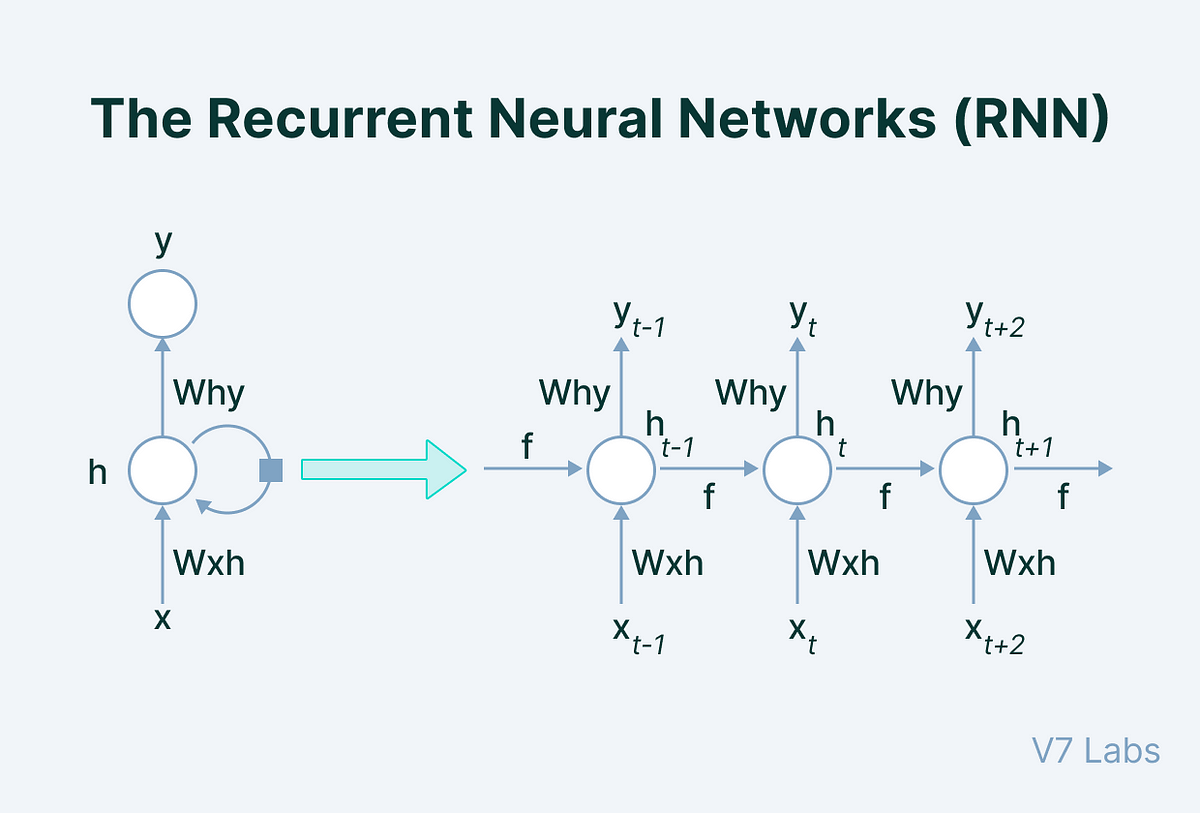

### 1. Cálculo del estado oculto: 

El estado oculto $ℎ_{𝑡}$ en el tiempo $𝑡$ se actualiza usando la siguiente ecuación:

$$h_t = \sigma(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$


Donde:

​$h_t$:  es el estado oculto en el tiempo 𝑡.

$W_{hh}$: son los pesos recurrentes que conectan el estado anterior $ℎ_{𝑡-1}$ al nuevo estado.

​
$W_{xh}$:  son los pesos que conectan la entrada $𝑥_𝑡$ al estado oculto.

$b_h$: es el sesgo (bias).

$\sigma$: es la función de activación, que introduce no linealidad y controla los valores del estado oculto.

### 2. Salida de la red:

Después de calcular el estado oculto $ℎ_𝑡$​, la RNN genera una salida $𝑦_𝑡$​, que es una transformación lineal del estado oculto:

$$y_t = W_{hy} h_t + b_y$$


Donde:

$𝑦_𝑡$: es la salida en el tiempo $𝑡$.
​

$W_{hy}$:  son los pesos que conectan el estado oculto con la salida.

$𝑏_𝑦$:  es el sesgo aplicado a la salida.

## Ejemplo

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

In [2]:
# Corpus extendido de entrenamiento (20 frases)
corpus_entrenamiento = [
    "el perro corre rápido",
    "el gato duerme en la cama",
    "el perro y el gato juegan juntos",
    "el gato maulla cuando tiene hambre",
    "el perro ladra en la noche",
    "el sol brilla en el cielo",
    "la luna ilumina la noche",
    "las estrellas brillan en el cielo",
    "el caballo galopa por el campo",
    "el gato corre por la casa",
    "el perro salta sobre la cama",
    "el conejo salta en el jardín",
    "el ratón corre detrás del gato",
    "el elefante es muy grande",
    "el león es el rey de la selva",
    "el tigre caza en la selva",
    "el lobo aúlla en la noche",
    "la vaca da leche en la granja",
    "el gallo canta al amanecer",
    "el pato nada en el lago"
]

# Corpus de validación (5 frases)
corpus_validacion = [
    "el gato juega en el jardín",
    "el perro duerme en la casa",
    "el conejo come zanahorias",
    "el león ruge en la selva",
    "el ratón se esconde en la madriguera"
]


In [3]:
# Tokenización y creación del vocabulario
vocabulario = list(set(" ".join(corpus_entrenamiento + corpus_validacion).split()))
vocab_size = len(vocabulario)
word_to_idx = {word: i for i, word in enumerate(vocabulario)}
idx_to_word = {i: word for i, word in enumerate(vocabulario)}

print(f"Vocabulario: {vocabulario}")
print(f"Índices de palabras: {word_to_idx}")

Vocabulario: ['lobo', 'elefante', 'juegan', 'selva', 'ilumina', 'ruge', 'detrás', 'canta', 'campo', 'sol', 'estrellas', 'rápido', 'galopa', 'duerme', 'hambre', 'zanahorias', 'ratón', 'vaca', 'lago', 'del', 'las', 'cama', 'sobre', 'come', 'nada', 'leche', 'la', 'de', 'maulla', 'cuando', 'corre', 'tiene', 'por', 'grande', 'da', 'cielo', 'juega', 'es', 'noche', 'brillan', 'muy', 'salta', 'granja', 'amanecer', 'león', 'caballo', 'pato', 'rey', 'aúlla', 'gato', 'ladra', 'y', 'conejo', 'jardín', 'perro', 'se', 'el', 'luna', 'en', 'tigre', 'al', 'caza', 'esconde', 'casa', 'madriguera', 'gallo', 'juntos', 'brilla']
Índices de palabras: {'lobo': 0, 'elefante': 1, 'juegan': 2, 'selva': 3, 'ilumina': 4, 'ruge': 5, 'detrás': 6, 'canta': 7, 'campo': 8, 'sol': 9, 'estrellas': 10, 'rápido': 11, 'galopa': 12, 'duerme': 13, 'hambre': 14, 'zanahorias': 15, 'ratón': 16, 'vaca': 17, 'lago': 18, 'del': 19, 'las': 20, 'cama': 21, 'sobre': 22, 'come': 23, 'nada': 24, 'leche': 25, 'la': 26, 'de': 27, 'maulla'

In [4]:
# Dataset personalizado
class TextDataset(Dataset):
    def __init__(self, corpus, word_to_idx):
        self.data = [[word_to_idx[word] for word in oracion.split()] for oracion in corpus]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        input_seq = torch.LongTensor(seq[:-1])  # Todas menos la última palabra
        target_seq = torch.LongTensor(seq[1:])  # Todas menos la primera palabra (predicción de la siguiente palabra)
        return input_seq, target_seq

In [5]:
# Crear los datasets de entrenamiento y validación
dataset_entrenamiento = TextDataset(corpus_entrenamiento, word_to_idx)
dataset_validacion = TextDataset(corpus_validacion, word_to_idx)

In [9]:
dataset_entrenamiento.data[:4]

[[56, 54, 30, 11],
 [56, 49, 13, 58, 26, 21],
 [56, 54, 51, 56, 49, 2, 66],
 [56, 49, 28, 29, 31, 14]]

In [12]:
dataset_entrenamiento.__getitem__(0)

(tensor([56, 54, 30]), tensor([54, 30, 11]))

In [ ]:
batch_size = 4
dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)

In [ ]:
for i, o in dataloader_validacion:
    print(i)

RuntimeError: stack expects each tensor to be equal size, but got [5] at entry 0 and [3] at entry 2

In [ ]:
dataset_validacion.__getitem__(0), dataset_validacion.__getitem__(2) 

((tensor([56, 49, 36, 58, 56]), tensor([49, 36, 58, 56, 53])),
 (tensor([56, 52, 23]), tensor([52, 23, 15])))

El problema original era causado por las secuencias de diferentes longitudes que se estaban intentando apilar en un solo tensor. Para solucionarlo, hemos implementado padding usando la función pad_sequence de PyTorch, y hemos creado una función de colación personalizada que se asegura de que todas las secuencias en un lote tengan el mismo tamaño antes de ser procesadas por el modelo.

Ahora deberías poder entrenar el modelo sin errores relacionados con las diferentes longitudes de las secuencias.

In [51]:
# Función personalizada de colación que rellena las secuencias
def collate_fn(batch):
    inputs = [item[0] for item in batch]  # Secuencias de entrada
    targets = [item[1] for item in batch]  # Secuencias objetivo (targets)
    
    # Rellenar secuencias con ceros para que todas tengan la misma longitud
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    return inputs_padded, targets_padded

In [52]:
# Crear DataLoader para ambos conjuntos de datos
batch_size = 4
dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [54]:
j=0
for i, o in dataloader_validacion:
    print('Estos son los inputs', i)
    j += 1
    if j == 1:
        break

Estos son los inputs tensor([[56, 49, 36, 58, 56],
        [56, 54, 13, 58, 26],
        [56, 52, 23,  0,  0],
        [56, 44,  5, 58, 26]])


In [55]:
# Definir el modelo RNN
class ModeloRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(ModeloRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        output = self.fc(rnn_out)
        return output


In [56]:
# Definir los parámetros del modelo
embedding_dim = 10
hidden_dim = 50
output_dim = vocab_size

modelo_rnn = ModeloRNN(vocab_size, embedding_dim, hidden_dim, output_dim)

In [57]:
# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(modelo_rnn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [58]:
# Función para entrenar el modelo
def entrenar_modelo(modelo, dataloader, optimizer, criterion, num_epochs=50):
    modelo.train()  # Modo de entrenamiento
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()

            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Pérdida total: {total_loss:.4f}")


In [60]:
# Entrenar el modelo
entrenar_modelo(modelo_rnn, dataloader_entrenamiento, optimizer, criterion, num_epochs=50)

Epoch: 10/50, Pérdida total: 2.2436
Epoch: 20/50, Pérdida total: 2.2976
Epoch: 30/50, Pérdida total: 2.2756
Epoch: 40/50, Pérdida total: 2.3107
Epoch: 50/50, Pérdida total: 2.3329


In [61]:
# Función para validar el modelo
def validar_modelo(modelo, dataloader, criterion):
    modelo.eval()  # Poner el modelo en modo de evaluación
    total_loss = 0
    with torch.no_grad():  # Desactivar el cálculo del gradiente
        for inputs, targets in dataloader:
            outputs = modelo(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)  # Promediar el loss
    return avg_loss

In [62]:
# Función para entrenar el modelo y graficar el loss de entrenamiento y validación
def entrenar_modelo_con_validacion(modelo, dataloader_entrenamiento, dataloader_validacion, optimizer, criterion, num_epochs=50):
    modelo.train()  # Modo de entrenamiento
    train_losses = []  # Lista para almacenar el loss de cada epoch (entrenamiento)
    valid_losses = []  # Lista para almacenar el loss de cada epoch (validación)
    
    for epoch in range(num_epochs):
        modelo.train()  # Asegurarse de estar en modo de entrenamiento
        total_train_loss = 0
        for inputs, targets in dataloader_entrenamiento:
            optimizer.zero_grad()

            # Forward pass
            outputs = modelo(inputs)
            loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Almacenar el loss promedio de la época
        avg_train_loss = total_train_loss / len(dataloader_entrenamiento)
        train_losses.append(avg_train_loss)

        # Validar el modelo en el conjunto de validación
        avg_valid_loss = validar_modelo(modelo, dataloader_validacion, criterion)
        valid_losses.append(avg_valid_loss)

        # Imprimir el loss de entrenamiento y validación cada 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Pérdida de Entrenamiento: {avg_train_loss:.4f}, Pérdida de Validación: {avg_valid_loss:.4f}")
    
    # Graficar la evolución del loss durante el entrenamiento y la validación
    plt.plot(range(1, num_epochs + 1), train_losses, label='Loss Entrenamiento')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Loss Validación')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolución del Loss en Entrenamiento y Validación')
    plt.legend()
    plt.show()


Epoch: 10/50, Pérdida de Entrenamiento: 0.4438, Pérdida de Validación: 7.4045
Epoch: 20/50, Pérdida de Entrenamiento: 0.4667, Pérdida de Validación: 7.4134
Epoch: 30/50, Pérdida de Entrenamiento: 0.4669, Pérdida de Validación: 7.4330
Epoch: 40/50, Pérdida de Entrenamiento: 0.4434, Pérdida de Validación: 7.4472
Epoch: 50/50, Pérdida de Entrenamiento: 0.4492, Pérdida de Validación: 7.4480


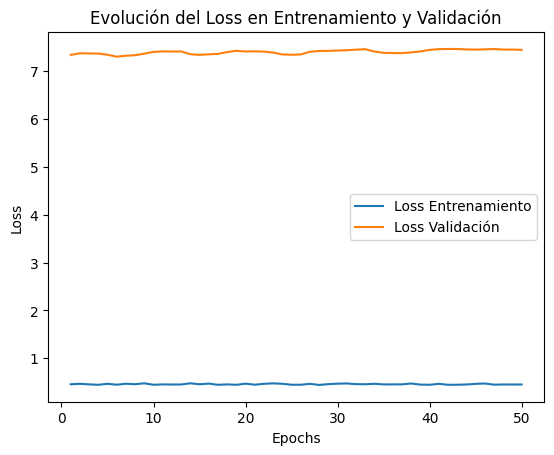

In [63]:
# Entrenar y validar el modelo
entrenar_modelo_con_validacion(modelo_rnn, dataloader_entrenamiento, dataloader_validacion, optimizer, criterion, num_epochs=50)

In [64]:
# Función para predecir la siguiente palabra
def predecir_siguiente_palabra(modelo, secuencia_inicial, word_to_idx, idx_to_word, max_len=5):
    modelo.eval()  # Poner el modelo en modo de evaluación
    words = secuencia_inicial.split()  # Tokenizar la oración inicial
    indices_iniciales = [word_to_idx[word] for word in words if word in word_to_idx]  # Convertir palabras a índices

    if len(indices_iniciales) == 0:
        print("La secuencia inicial no contiene palabras en el vocabulario.")
        return None

    input_seq = torch.LongTensor(indices_iniciales).unsqueeze(0)  # Crear tensor de la secuencia inicial

    with torch.no_grad():
        # Pasar la secuencia por la RNN para obtener la predicción de la siguiente palabra
        salida = modelo(input_seq)
        pred_idx = salida[:, -1, :].argmax(dim=1).item()  # Tomar la palabra más probable (última salida)

    # Convertir el índice predicho en palabra
    palabra_predicha = idx_to_word[pred_idx]
    return palabra_predicha

In [69]:
# Probar la predicción con una oración inicial
secuencia_inicial = "el gato"
secuencia_inicial = "en la cama"
secuencia_inicial = "estrella galopa duerme"
palabra_predicha = predecir_siguiente_palabra(modelo_rnn, secuencia_inicial, word_to_idx, idx_to_word)
print(f"Predicción para la secuencia '{secuencia_inicial}': {palabra_predicha}")

Predicción para la secuencia 'estrella galopa duerme': canta
